In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA3%20mobilities%20eligible%20finalised%20started%20in%202014-2019.csv?inline=false')
reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA1%20mobilities%20eligible%20finalised%20started%20in%202018.csv?inline=false')
reply.encoding = 'utf-8'

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)
df.drop(columns=['GroupLeader', 'Sending Organisation Erasmus Code', 'Receiving Organisation Erasmus Code'], inplace=True)
c_df = df.copy() # we will use it for later (country network)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 GroupLeader
14 Participant Age
15 Sending Country Code
16 Sending City
17 Sending Organization
18 Sending Organisation Erasmus Code
19 Receiving Country Code
20 Receiving City
21 Receiving Organization
22 Receiving Organisation Erasmus Code
23 Participants


In [4]:
pd.options.display.max_columns=21
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690326,2018-2-UK01-KA125-048625,2018-2019,2018-09,2019-07,319.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Female,Learner,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
690327,2018-2-UK01-KA125-048626,2018-2019,2018-10,2019-03,137.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Male,Learner,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690328,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-04,170.0,Individual Volunteering Activities,? Unknown ?,CZ,??? - ? Unknown ?,Female,Learner,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690329,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-10,351.0,Individual Volunteering Activities,? Unknown ?,FR,??? - ? Unknown ?,Male,Learner,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


In [5]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 15, 18))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

3789
4306


In [6]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df

Number of Receiving Universities:  3696
Number of Sending Universities:  4227


,Sending Organization,Receiving Organization,Participants,Activity (mob),Sending City,Receiving City
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...,FELDKIRCH,LUND
195,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...,LEOBEN,Saint-Petersburg
202,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
203,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
204,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
...,...,...,...,...,...,...
668733,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668734,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668735,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668736,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

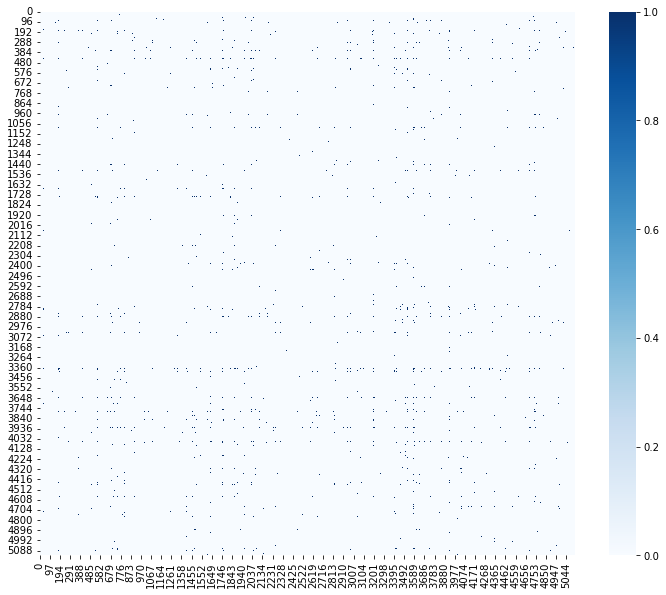

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
uni_cities = mobility_df.copy()
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

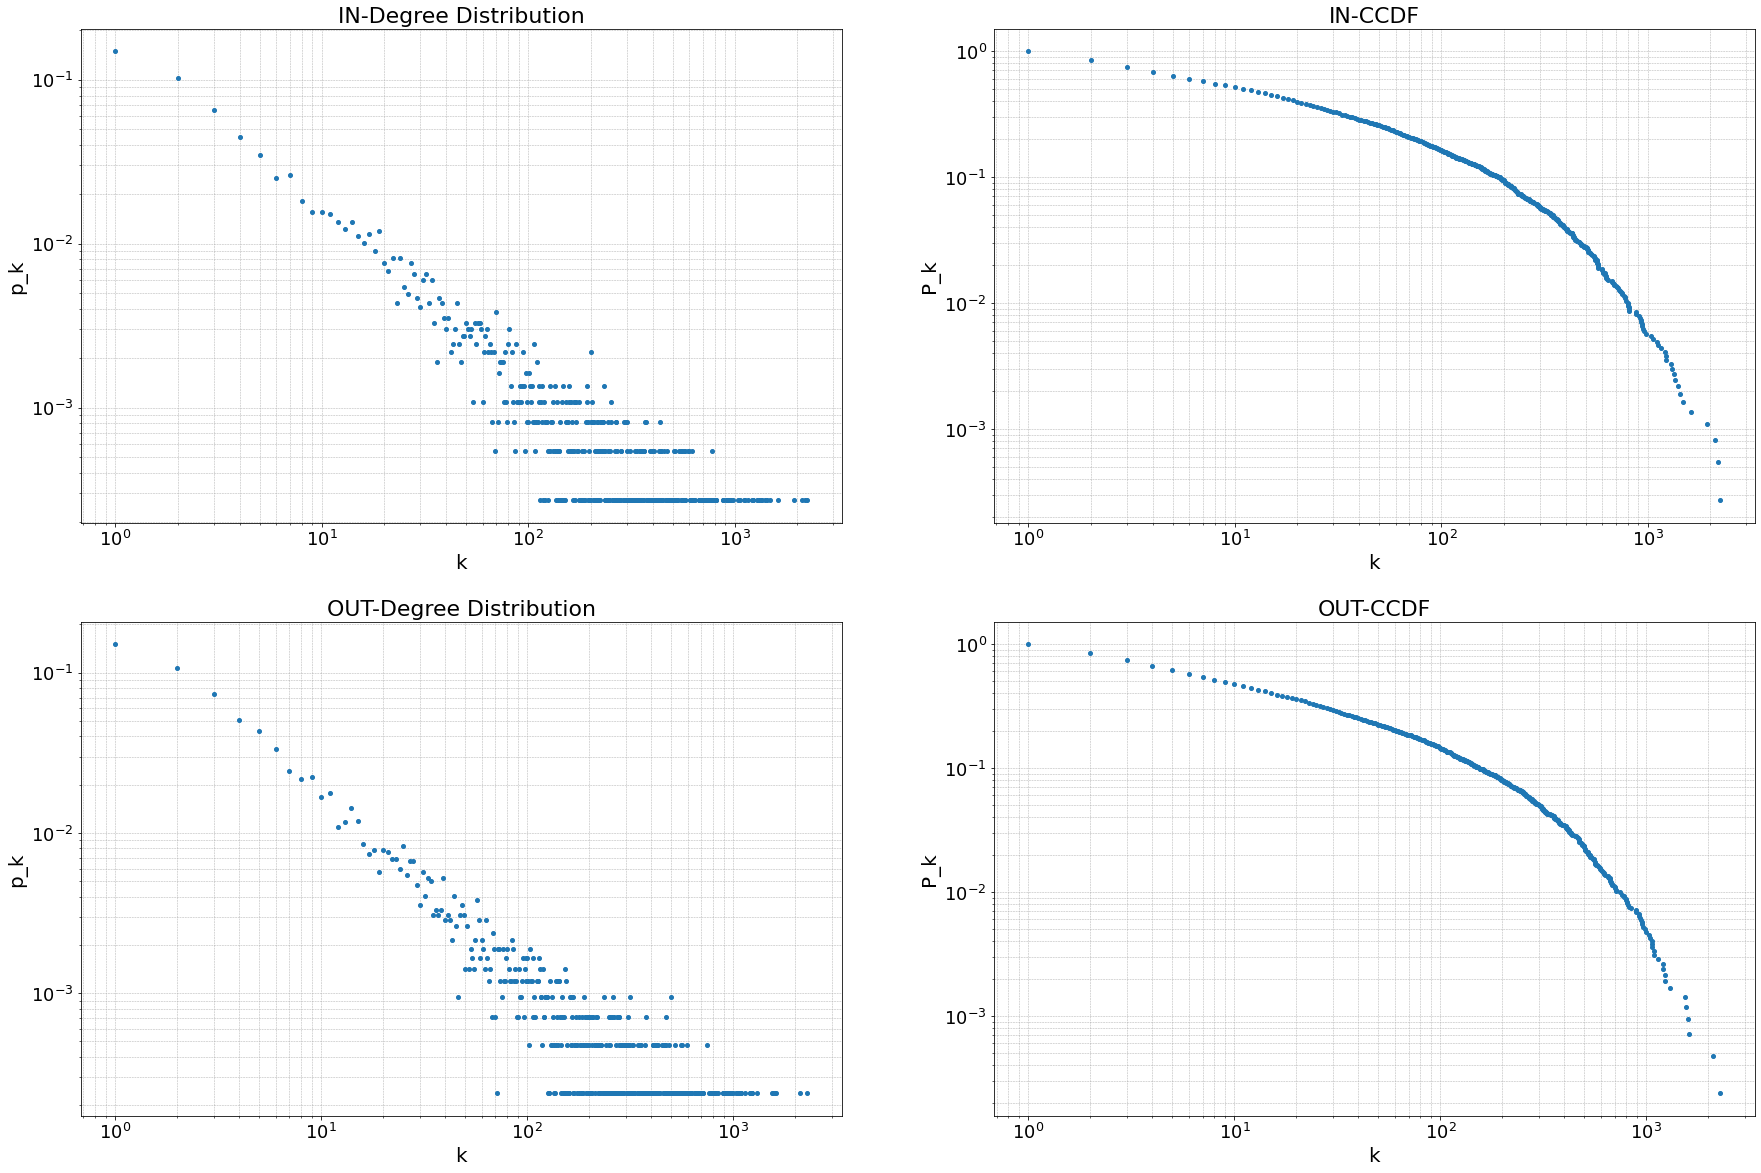

Top 10 for in degree


,Nodes,in degree
3952,UNIVERSITAT DE VALENCIA,2238
3383,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2179
5039,UNIVERSIDADE DE LISBOA,2118
854,UNIVERSIDAD DE GRANADA,1931
3839,UNIVERSIDAD COMPLUTENSE DE MADRID,1612
3991,UNIVERZA V LJUBLJANI,1481
3555,UNIVERSITAT POLITECNICA DE VALENCIA,1434
240,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1405
4029,UNIVERSIDAD DE SEVILLA,1350
239,KATHOLIEKE UNIVERSITEIT LEUVEN,1341


Top 10 for out degree


,Nodes,out degree
3383,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
854,UNIVERSIDAD DE GRANADA,2114
3952,UNIVERSITAT DE VALENCIA,1604
3839,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
3344,UNIVERSITA DEGLI STUDI DI PADOVA,1563
4521,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
4064,UNIVERSITA DEGLI STUDI DI TORINO,1299
5039,UNIVERSIDADE DE LISBOA,1228
239,KATHOLIEKE UNIVERSITEIT LEUVEN,1225
2631,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1203


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [12]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [13]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

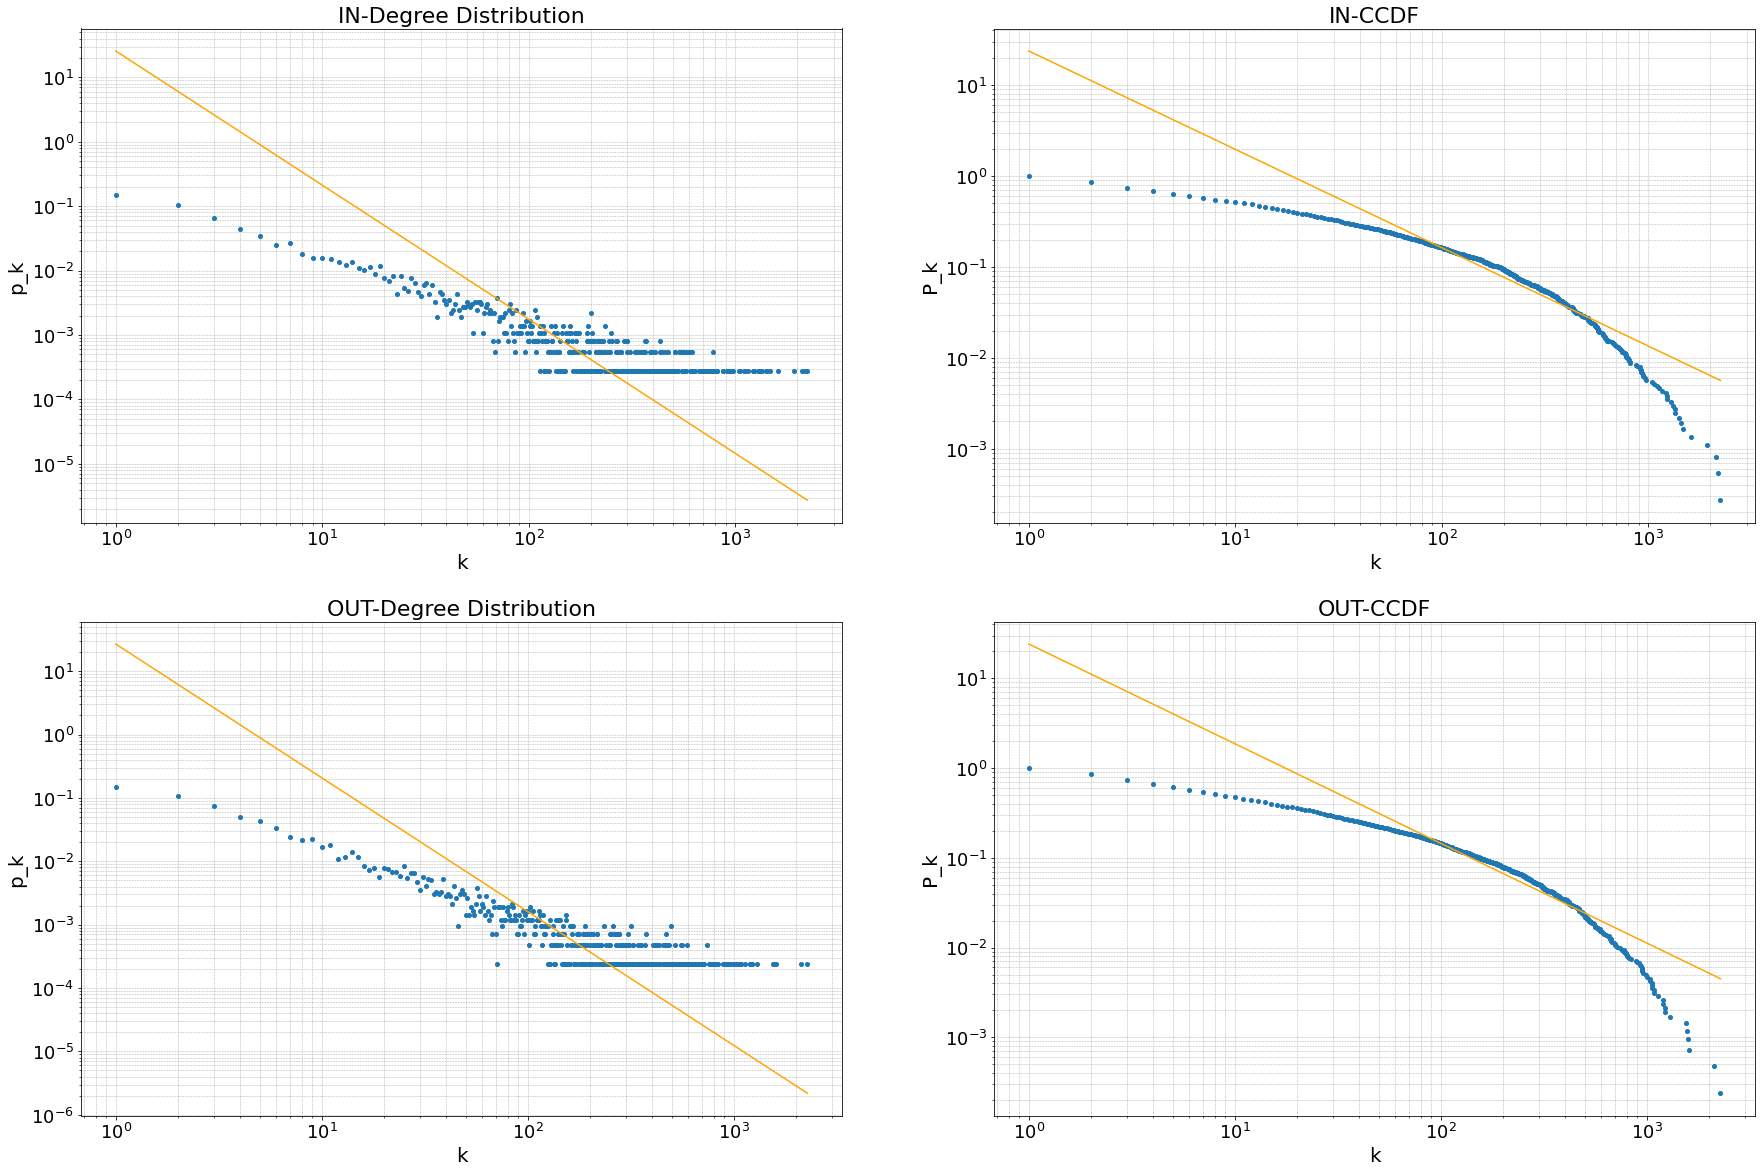

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [15]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

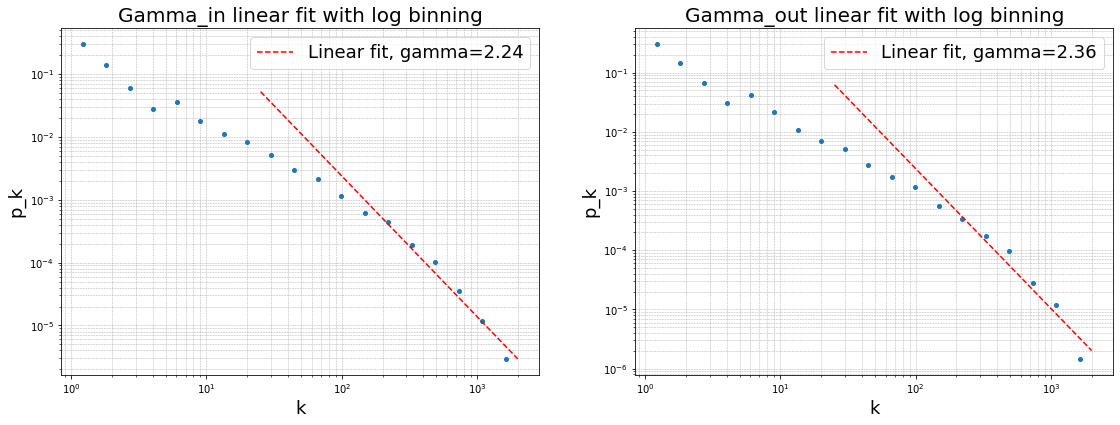

In [16]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

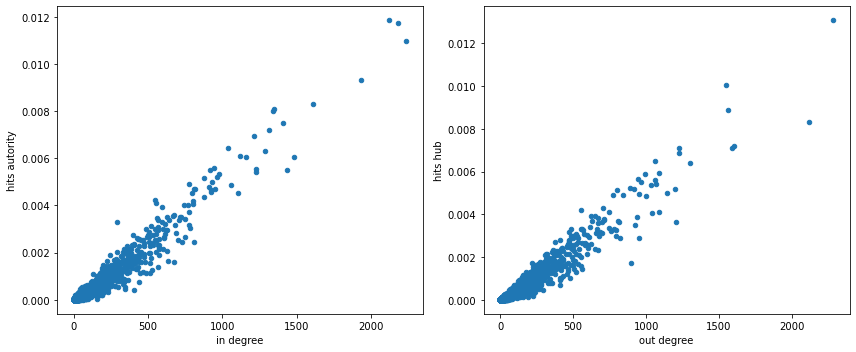

Top 10 for hits hub


,Nodes,hits hub
3383,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013068
4521,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010048
3344,UNIVERSITA DEGLI STUDI DI PADOVA,0.008881
854,UNIVERSIDAD DE GRANADA,0.008339
3952,UNIVERSITAT DE VALENCIA,0.007203
5039,UNIVERSIDADE DE LISBOA,0.007114
3839,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007107
239,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006883
2979,TECHNISCHE UNIVERSITAET MUENCHEN,0.006487
4064,UNIVERSITA DEGLI STUDI DI TORINO,0.006378


Top 10 for hits autority


,Nodes,hits autority
5039,UNIVERSIDADE DE LISBOA,0.011846
3383,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011721
3952,UNIVERSITAT DE VALENCIA,0.010979
854,UNIVERSIDAD DE GRANADA,0.009306
3839,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008310
4029,UNIVERSIDAD DE SEVILLA,0.008109
239,KATHOLIEKE UNIVERSITEIT LEUVEN,0.008007
240,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007508
3155,UNIVERZITA KARLOVA,0.007196
2754,UNIVERSITAT DE BARCELONA,0.006963


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

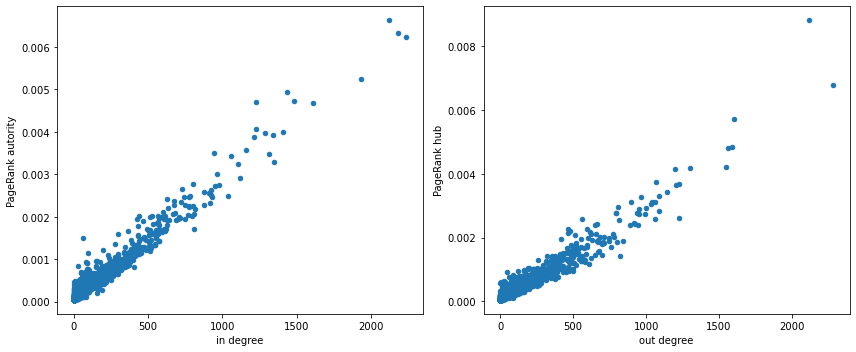

Top 10 for PageRank hub


,Nodes,PageRank hub
854,UNIVERSIDAD DE GRANADA,0.008810
3383,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006786
3952,UNIVERSITAT DE VALENCIA,0.005716
3839,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004823
3344,UNIVERSITA DEGLI STUDI DI PADOVA,0.004807
4521,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004214
4064,UNIVERSITA DEGLI STUDI DI TORINO,0.004182
3009,UNIVERSIDAD POLITECNICA DE MADRID,0.004139
3991,UNIVERZA V LJUBLJANI,0.003745
5039,UNIVERSIDADE DE LISBOA,0.003693


Top 10 for PageRank autority


,Nodes,PageRank autority
5039,UNIVERSIDADE DE LISBOA,0.006626
3383,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006335
3952,UNIVERSITAT DE VALENCIA,0.006226
854,UNIVERSIDAD DE GRANADA,0.005244
3555,UNIVERSITAT POLITECNICA DE VALENCIA,0.004949
3991,UNIVERZA V LJUBLJANI,0.004723
4188,POLITECNICO DI MILANO,0.004714
3839,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004670
3344,UNIVERSITA DEGLI STUDI DI PADOVA,0.004074
240,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.003990


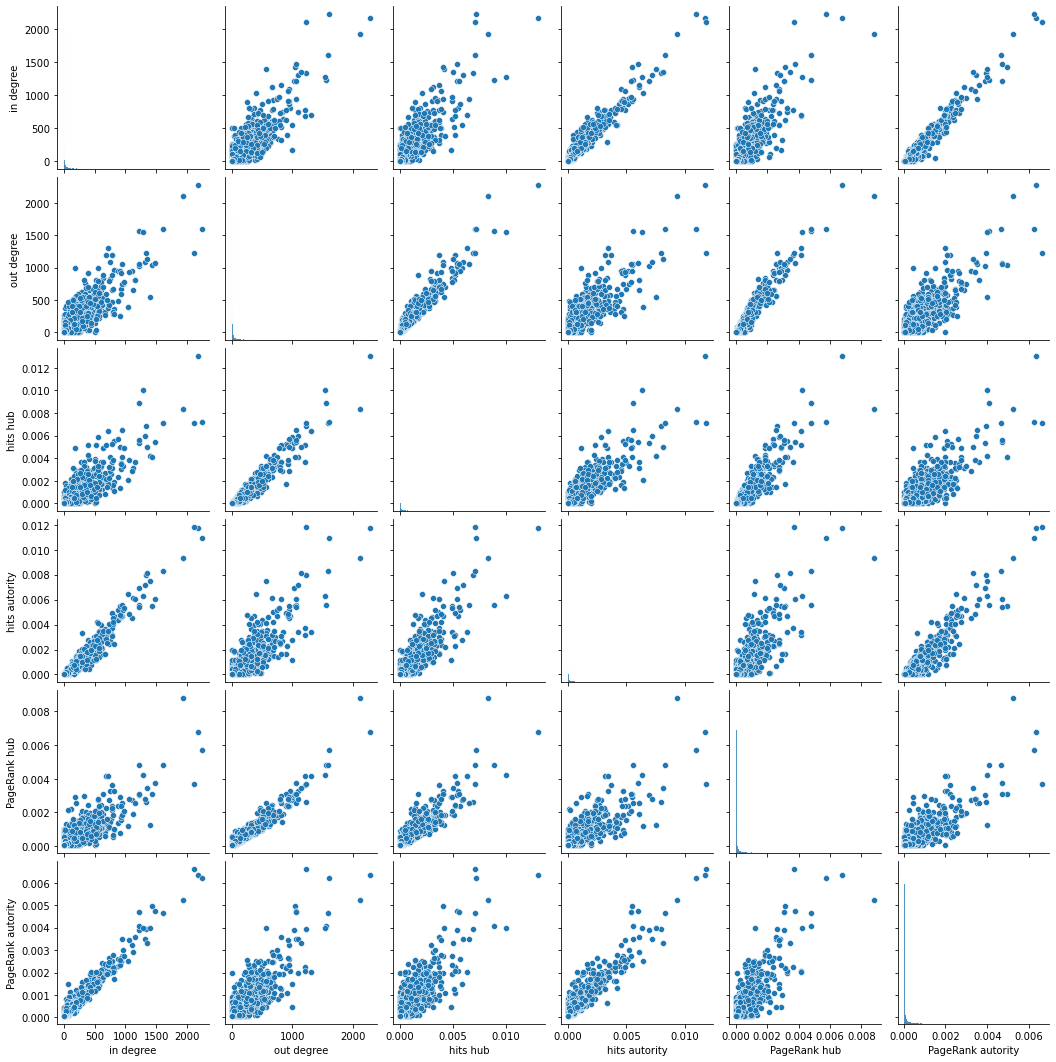

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

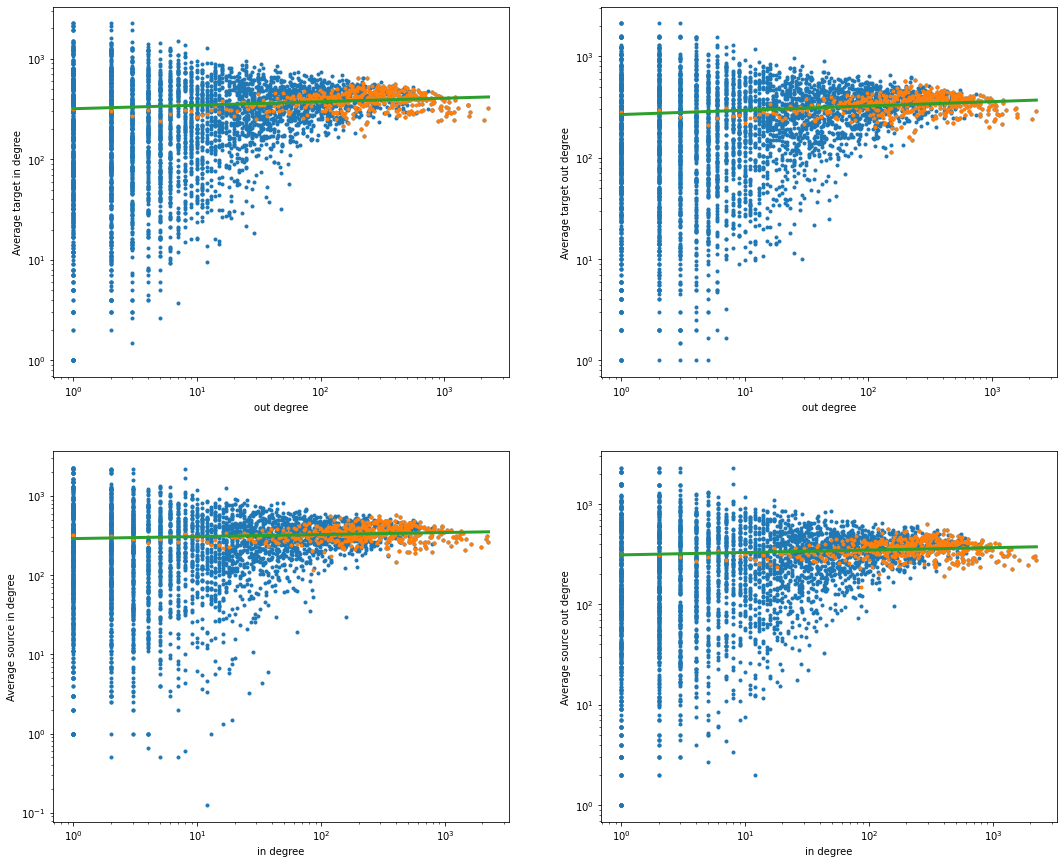

(0.034832263162413606,
 0.04243076951818893,
 0.02551010144932137,
 0.02403733513504581)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Robustness

In [20]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


KeyboardInterrupt: 

In [ ]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()

## Communities

In [ ]:
import networkx as nx

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()
node_comm.drop(columns=['NodeID'], inplace=True)

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])
    
scores['Community'] = node_comm['Community']
# 52 communities. Choose if it makes sense to reduce the number of them 

## Geographical heatmap

In [21]:
temp_df = uni_cities[['target', 'Receiving City']].copy()
temp_df.rename({'target':'source', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['source', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)

for index in range(cities_uni.shape[0]):
    city = cities_uni.iat[index,1]
    if city != city.upper():
        cities_uni.iat[index,1] = city.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)
cities_uni = cities_uni.drop_duplicates(subset='source').reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['source'] == u, 'Sending City'])[0])

scores_cities = scores.copy()
scores_cities['City'] = cities_list

scores_cities

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,City
0,UNIVERSITA CARLO CATTANEO LIUC,0,38,0,0,0.000000e+00,3.673697e-05,0,0.000045,0.000197,CASTELLANZA
1,VID VITENSKAPELIGE HØGSKOLE,1,8,0,1,0.000000e+00,2.684685e-07,1,0.000045,0.000124,OSLO
2,ESCOLA ART I SUPERIOR DISSENY I.B.,2,7,0,2,0.000000e+00,6.057614e-06,2,0.000045,0.000066,PALMA DE MALLORCA
3,GROUPE ESC PAU - IFSAC IPC,3,11,1,3,1.292132e-06,3.722152e-05,3,0.000047,0.000078,PAU
4,NED UNIVERSITY OF ENGINEERING AND TECHNOLOGY,4,0,2,4,6.795156e-07,0.000000e+00,4,0.000057,0.000043,KARACHI
...,...,...,...,...,...,...,...,...,...,...,...
5094,BELARUS STATE ECONOMIC UNIVERSITY,5094,0,7,5094,2.403954e-05,0.000000e+00,5094,0.000065,0.000043,MINSK
5095,RUDN UNIVERSITY,5095,0,2,5095,9.075961e-06,0.000000e+00,5095,0.000052,0.000043,MOSCOW
5096,FONDATION LA MACHE,5096,5,22,5096,2.927431e-05,1.305216e-06,5096,0.000089,0.000082,69373 LYON CEDEX 08
5097,BEIJING SPORT UNIVERSITY,5097,0,6,5097,2.391687e-05,0.000000e+00,5097,0.000065,0.000043,BEIJING


In [22]:
city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities

# some cities are missing like Milano, Torino, Madrid (these are also pretty much important)

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,City,city,city_ascii,lat,lng,iso2,admin_name
0,UNIVERSITA CARLO CATTANEO LIUC,0,38,0,0,0.000000e+00,3.673697e-05,0,0.000045,0.000197,CASTELLANZA,CASTELLANZA,Castellanza,45.6167,8.9000,IT,Lombardy
1,VID VITENSKAPELIGE HØGSKOLE,1,8,0,1,0.000000e+00,2.684685e-07,1,0.000045,0.000124,OSLO,OSLO,Oslo,59.9111,10.7528,NO,Oslo
2,GROUPE ESC PAU - IFSAC IPC,3,11,1,3,1.292132e-06,3.722152e-05,3,0.000047,0.000078,PAU,PAU,Pau,43.3000,-0.3700,FR,Nouvelle-Aquitaine
3,NED UNIVERSITY OF ENGINEERING AND TECHNOLOGY,4,0,2,4,6.795156e-07,0.000000e+00,4,0.000057,0.000043,KARACHI,KARACHI,Karachi,24.8600,67.0100,PK,Sindh
4,UNIVERSITY OF DELHI,5,0,4,5,1.559918e-05,0.000000e+00,5,0.000061,0.000043,NEW DELHI,NEW DELHI,New Delhi,28.7000,77.2000,IN,Delhi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,EZZITOUNA UNIVERSITY,5093,0,1,5093,5.876545e-07,0.000000e+00,5093,0.000050,0.000043,TUNIS,TUNIS,Tunis,36.8008,10.1800,TN,Tunis
3520,BELARUS STATE ECONOMIC UNIVERSITY,5094,0,7,5094,2.403954e-05,0.000000e+00,5094,0.000065,0.000043,MINSK,MINSK,Minsk,53.9022,27.5618,BY,Minsk
3521,RUDN UNIVERSITY,5095,0,2,5095,9.075961e-06,0.000000e+00,5095,0.000052,0.000043,MOSCOW,MOSCOW,Moscow,55.7558,37.6178,RU,Moskva
3522,BEIJING SPORT UNIVERSITY,5097,0,6,5097,2.391687e-05,0.000000e+00,5097,0.000065,0.000043,BEIJING,BEIJING,Beijing,39.9050,116.3914,CN,Beijing


In [23]:
scores_cities[['Nodes', 'PageRank hub']].sort_values('PageRank hub', ascending=False).head(10)

,Nodes,PageRank hub
596,UNIVERSIDAD DE GRANADA,0.008810
2362,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006786
2750,UNIVERSITAT DE VALENCIA,0.005716
2675,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004823
2338,UNIVERSITA DEGLI STUDI DI PADOVA,0.004807
3136,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004214
2092,UNIVERSIDAD POLITECNICA DE MADRID,0.004139
2776,UNIVERZA V LJUBLJANI,0.003745
2798,UNIVERSIDAD DE SEVILLA,0.003441
324,UNIVERSIDAD DE ZARAGOZA,0.003294


In [24]:
scores[['Nodes', 'PageRank hub']].sort_values('PageRank hub', ascending=False).head(10)

,Nodes,PageRank hub
854,UNIVERSIDAD DE GRANADA,0.008810
3383,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006786
3952,UNIVERSITAT DE VALENCIA,0.005716
3839,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004823
3344,UNIVERSITA DEGLI STUDI DI PADOVA,0.004807
4521,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004214
4064,UNIVERSITA DEGLI STUDI DI TORINO,0.004182
3009,UNIVERSIDAD POLITECNICA DE MADRID,0.004139
3991,UNIVERZA V LJUBLJANI,0.003745
5039,UNIVERSIDADE DE LISBOA,0.003693


Importing geographic data also for countries

In [25]:
import geopandas as gpd
import pycountry as pc #library used for translating country codes from iso3 to iso2 standard

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# merge geometries with our dataframe
geo_scores = pd.merge(left=scores_cities, right=geo_df[['iso2_code', 'geometry']], how='left', 
                      left_on='iso2', right_on='iso2_code')
geo_scores = geo_scores[['Nodes', 'PageRank hub', 'PageRank autority', 'City', 'lat', 'lng', 'iso2', 'geometry']]
# geo_scores = gpd.GeoDataFrame(geo_scores, geometry = 'geometry')

divide universities by their country community

In [26]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

# def replace_iso3166(alpha):
#     try:
#         return pc.countries.get(alpha_2=alpha).name
#     except:
#         return alpha

# country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
# country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
# country_nodes['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), country_nodes['Nodes']))))

### 2 countries community
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')
for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')
# geo_scores = gpd.GeoDataFrame(geo_scores, geometry = 'geometry')

,Nodes,Community
0,FI,0
1,JP,0
9,BR,0
13,RO,0
16,BT,0
...,...,...
130,MW,0
135,MN,0
143,NG,0
144,KR,0


,Nodes,Community
3,CI,1
6,BF,1
7,HN,1
8,MR,1
12,MG,1
...,...,...
129,TW,1
131,SR,1
133,TM,1
139,ET,1


,Nodes,Community
4,PS,2
5,MD,2
10,MM,2
11,ME,2
15,MT,2
...,...,...
134,RU,2
136,UA,2
141,HR,2
142,LU,2


,Nodes,Community
20,BO,3
42,LK,3
57,TN,3
68,IN,3
73,JM,3
...,...,...
94,TL,3
104,PT,3
110,JO,3
121,NO,3


,Nodes,Community
2,CD,4
23,CH,4
79,LI,4
92,CM,4
97,BE,4
137,NI,4


In [27]:
geo_scores

,Nodes_x,PageRank hub,PageRank autority,City,lat,lng,iso2,geometry,Nodes_y,Community
0,UNIVERSITA CARLO CATTANEO LIUC,0.000045,0.000197,CASTELLANZA,45.6167,8.9000,IT,"MULTIPOLYGON (((12.621 35.492, 12.611 35.489, ...",IT,1.0
1,VID VITENSKAPELIGE HØGSKOLE,0.000045,0.000124,OSLO,59.9111,10.7528,NO,"MULTIPOLYGON (((3.383 -54.449, 3.365 -54.462, ...",NO,3.0
2,GROUPE ESC PAU - IFSAC IPC,0.000047,0.000078,PAU,43.3000,-0.3700,FR,"MULTIPOLYGON (((55.501 -20.873, 55.514 -20.875...",FR,1.0
3,NED UNIVERSITY OF ENGINEERING AND TECHNOLOGY,0.000057,0.000043,KARACHI,24.8600,67.0100,PK,"MULTIPOLYGON (((67.478 24.051, 67.485 24.049, ...",PK,2.0
4,UNIVERSITY OF DELHI,0.000061,0.000043,NEW DELHI,28.7000,77.2000,IN,"MULTIPOLYGON (((93.855 7.214, 93.865 7.201, 93...",IN,3.0
...,...,...,...,...,...,...,...,...,...,...
3519,EZZITOUNA UNIVERSITY,0.000050,0.000043,TUNIS,36.8008,10.1800,TN,"MULTIPOLYGON (((10.930 33.896, 10.960 33.866, ...",TN,3.0
3520,BELARUS STATE ECONOMIC UNIVERSITY,0.000065,0.000043,MINSK,53.9022,27.5618,BY,"POLYGON ((28.149 56.142, 28.169 56.125, 28.238...",BY,2.0
3521,RUDN UNIVERSITY,0.000052,0.000043,MOSCOW,55.7558,37.6178,RU,"MULTIPOLYGON (((132.449 42.845, 132.450 42.828...",RU,2.0
3522,BEIJING SPORT UNIVERSITY,0.000065,0.000043,BEIJING,39.9050,116.3914,CN,"MULTIPOLYGON (((111.205 15.779, 111.197 15.775...",CN,0.0


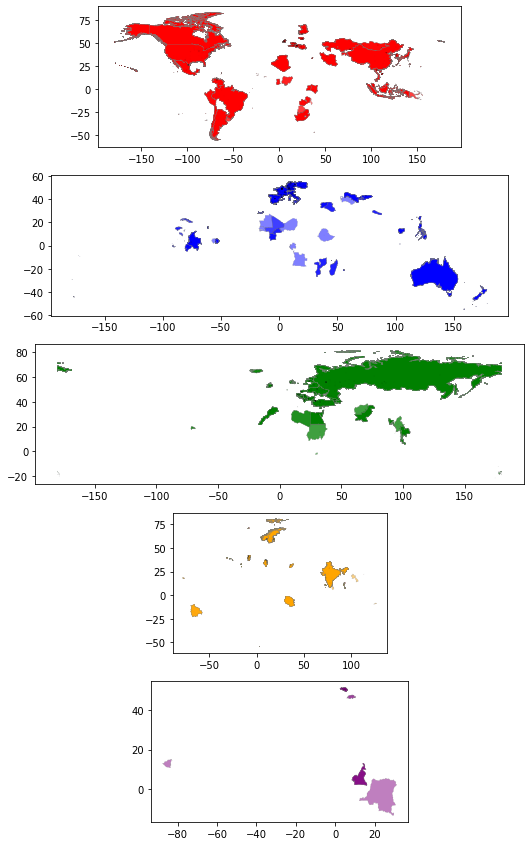

In [36]:
fig, ax = plt.subplots(5,1, figsize=(20,15))
colors = ['red', 'blue', 'green', 'orange', 'purple']
cmaps = ['Reds', 'Blues', 'Greens', 'Oranges', 'Purples']

for c in range(5):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax[c], edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.5)
    ax[c].scatter(x=temp_df['lng'], y=temp_df['lat'],s=temp_df['PageRank hub'], c='black')